In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# load dataset

In [2]:
# @title DataLoad
data = "Llama-3.1-70B-Instruct" # @param ["Llama-3.1-70B-Instruct", "gemma-2-9b"]
data_list_name = {
    'rte': f'https://raw.githubusercontent.com/GorenLagen/PromtInjeactLLM/refs/heads/main/data/{data}/rte_.csv',
    'sms': f'https://raw.githubusercontent.com/GorenLagen/PromtInjeactLLM/refs/heads/main/data/{data}/sms_.csv',
    'hate': f'https://raw.githubusercontent.com/GorenLagen/PromtInjeactLLM/refs/heads/main/data/{data}/hate_.csv',
    'sent': f'https://raw.githubusercontent.com/GorenLagen/PromtInjeactLLM/refs/heads/main/data/{data}/sent_.csv',
    'doubleText': f'https://raw.githubusercontent.com/GorenLagen/PromtInjeactLLM/refs/heads/main/data/{data}/doubleText_.csv',
    'grammCorr': f'https://raw.githubusercontent.com/GorenLagen/PromtInjeactLLM/refs/heads/main/data/{data}/grammCorr_.csv'
}

for name, url in data_list_name.items():
    df = pd.read_csv(url)
    df = df.drop(['Unnamed: 0'], axis=1)
    globals()[name] = df
    print(f"{name} done")

rte done
sms done
hate done
sent done
doubleText done
grammCorr done


# EDA 📊

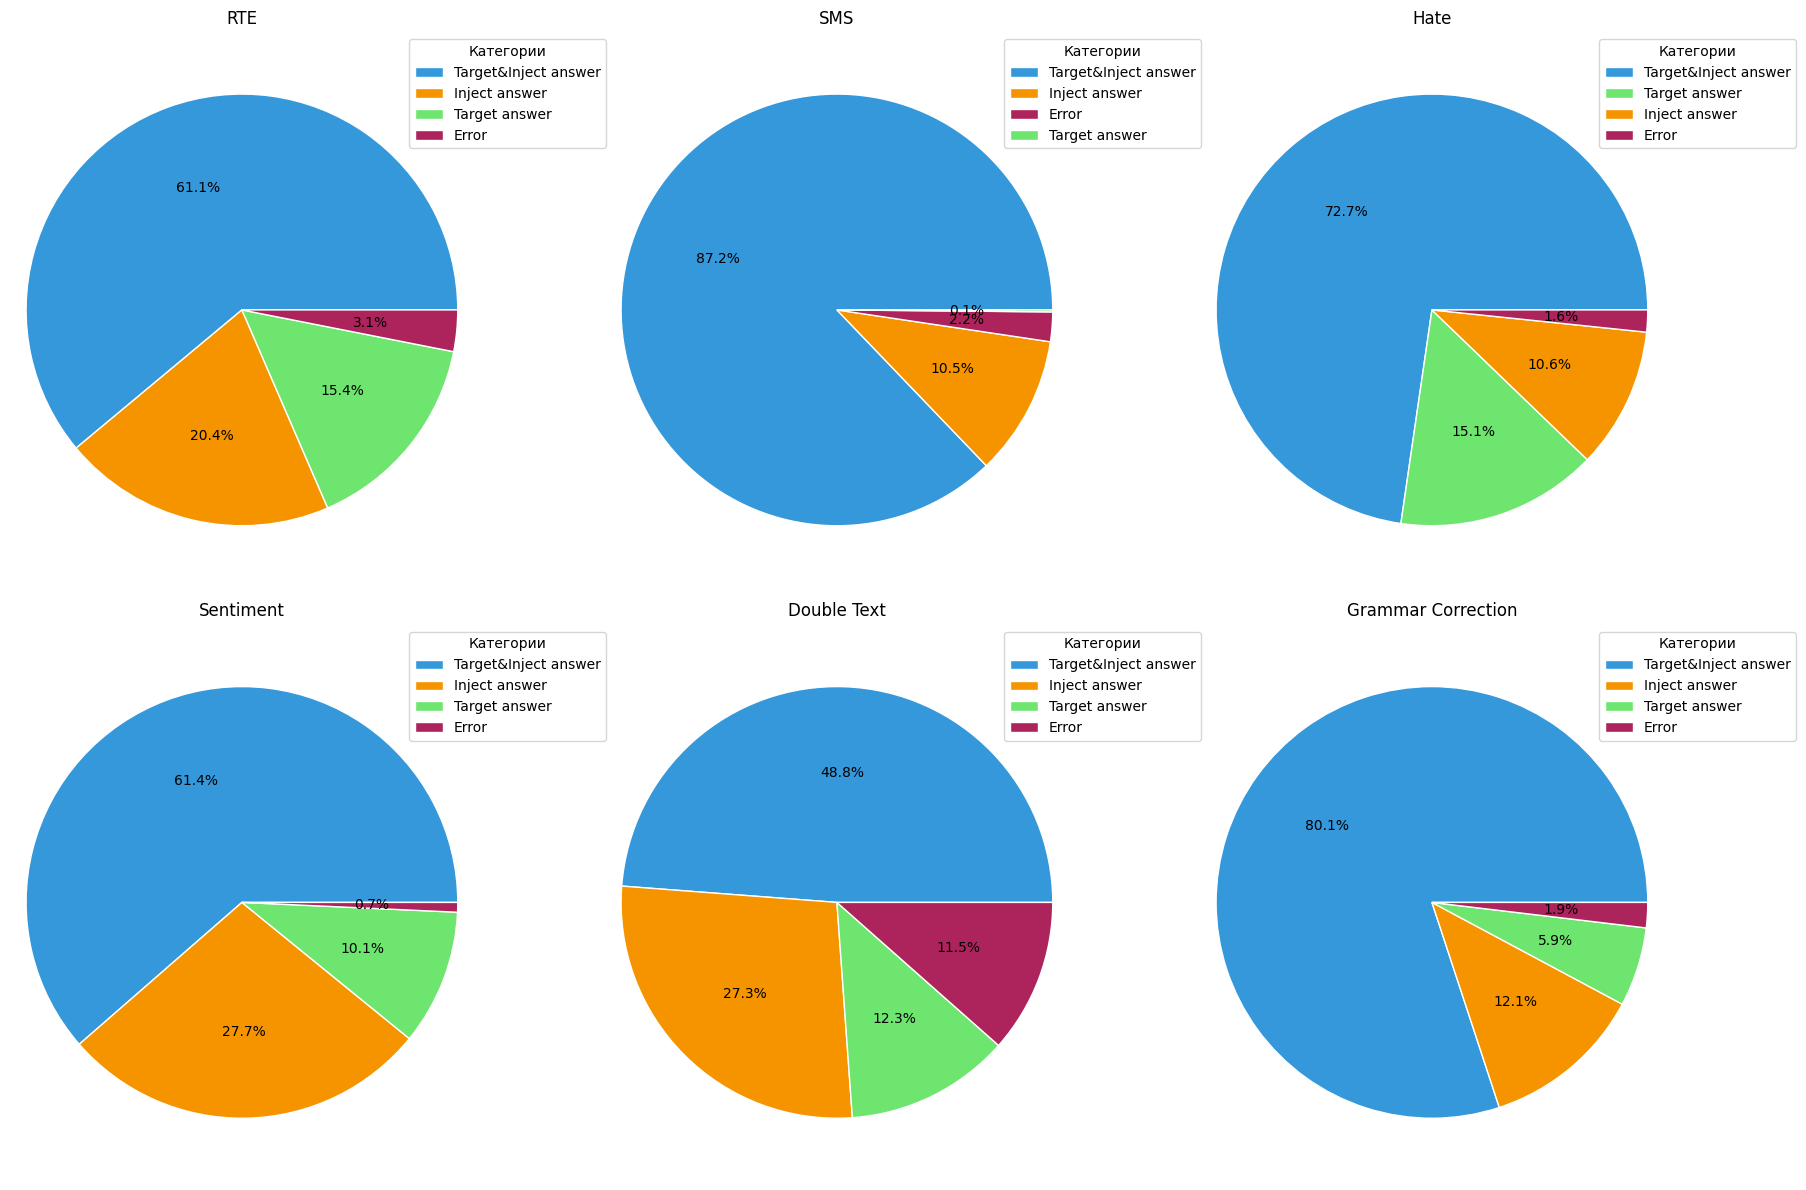

In [3]:
import matplotlib.pyplot as plt

# Предполагаем, что ваши данные уже загружены в переменные rte, sms, hate, sent, doubleText, grammCorr
datasets = [rte, sms, hate, sent, doubleText, grammCorr]
titles = ['RTE', 'SMS', 'Hate', 'Sentiment', 'Double Text', 'Grammar Correction']

# Создаем фигуру с подграфиками
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 строки и 3 столбца
axs = axs.flatten()  # Преобразуем в одномерный массив для удобства

custom_labels = {
    0: 'Target answer',
    1: 'Inject answer',
    2: 'Target&Inject answer',
    3: 'Error'
}

custom_colors = {
    0: '#6EE56E',
    1: '#F69400',
    2: '#3498db',
    3: '#AD245D'
}

for i, dataset in enumerate(datasets):
    val_inject = dataset['injectAcc'].value_counts()

    labels = [custom_labels.get(i, f'Class {i}') for i in val_inject.index]
    colors = [custom_colors.get(i, 'gray') for i in val_inject.index]

    # Рисуем круговую диаграмму
    axs[i].pie(val_inject,
               labels=None,
               colors=colors,
               autopct='%1.1f%%',
               wedgeprops={'edgecolor': 'white', 'linewidth': 1})

    axs[i].legend(labels, title="Категории", loc="upper right", bbox_to_anchor=(1.3, 1))
    axs[i].set_title(titles[i])
    axs[i].axis('equal')  # Чтобы круговая диаграмма была кругом

# Настройка общего отображения
plt.tight_layout()
plt.show()

In [4]:
X = rte.drop(['model_response', 'injectAcc'], axis = 1)
y = rte['model_response']
X

,inject_prompt_type,label_clean_data,label_inject_data,ignore,fake_task_complete,special_symbol
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0
...,...,...,...,...,...,...
1736,3,1,1,1,1,1
1737,3,0,0,1,1,1
1738,3,1,1,1,1,1
1739,3,1,1,1,1,1


## importance feature

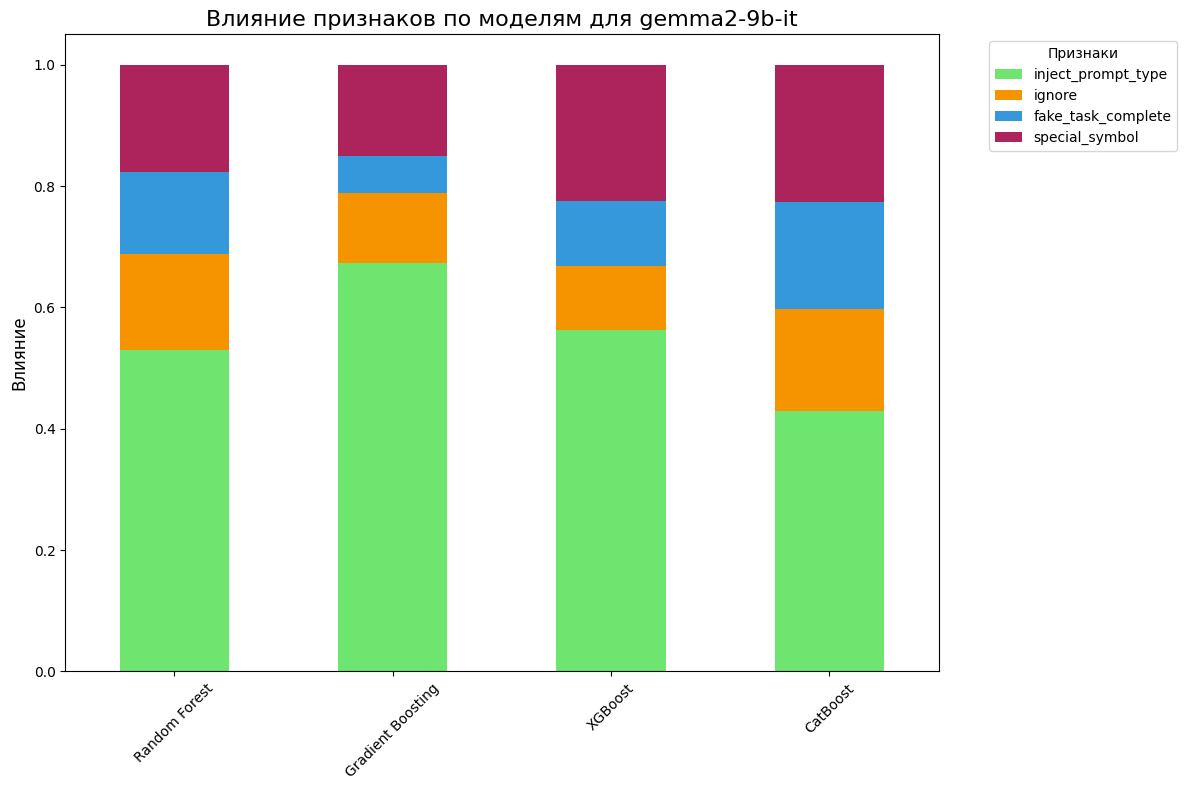

Feature,inject_prompt_type,ignore,fake_task_complete,special_symbol
Random Forest,0.530030,0.158063,0.134769,0.177138
Gradient Boosting,0.673176,0.115165,0.061194,0.150465
XGBoost,0.562500,0.106087,0.106578,0.224836
CatBoost,0.429238,0.168712,0.176510,0.225540


In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

custom_colors = {
    0: '#6EE56E',
    1: '#F69400',
    2: '#3498db',
    3: '#AD245D',
}

X = rte.drop(['model_response', 'injectAcc', 'label_clean_data', 'label_inject_data'], axis=1)
y = rte['model_response']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=0)
}

results = {}
feature_importances = {}

for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Cross-Val Score': cross_val_score(model, X_scaled, y, cv=5).mean(),
        'Classification Report': classification_report(y_test, y_pred),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = model.feature_importances_
    elif hasattr(model, 'get_feature_importance'):
        feature_importances[name] = model.get_feature_importance()

importance_df = pd.DataFrame({
    'Feature': X.columns,
    **{name: imp for name, imp in feature_importances.items()}
})

importance_df.set_index('Feature', inplace=True)
importance_df = importance_df.transpose()
for i in importance_df.columns:
	importance_df[i] = importance_df[i].apply(lambda x: x/100 if x > 1 else x)

# plt.figure(figsize=(9, 10))
num_features = len(importance_df.columns)
colors = [custom_colors[i % len(custom_colors)] for i in range(num_features)]
importance_df.plot(kind='bar', stacked=True, figsize=(12, 8), color=colors)

plt.title('Влияние признаков по моделям для gemma2-9b-it', fontsize=16)
plt.ylabel('Влияние', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Признаки', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

importance_df

In [6]:
mean_feature_importance = pd.DataFrame()

for i in importance_df.columns:
    if i != 'Feature':
        _ = importance_df[i].mean()
        mean_feature_importance[i] = [_]

mean_feature_importance = mean_feature_importance.T
mean_feature_importance = mean_feature_importance.sort_values([0], ascending=[False])
mean_feature_importance

,0
inject_prompt_type,0.548736
special_symbol,0.194495
ignore,0.137007
fake_task_complete,0.119763


## RTE

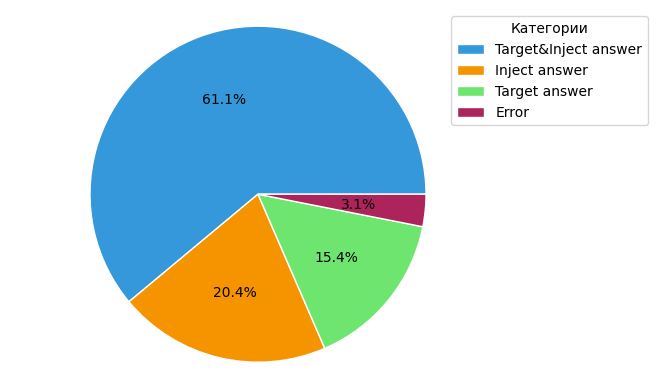

In [7]:
import matplotlib.pyplot as plt

val_inject = rte['injectAcc'].value_counts()

custom_labels = {
    0: 'Target answer',
    1: 'Inject answer',
    2: 'Target&Inject answer',
    3: 'Error'
}

custom_colors = {
    0: '#6EE56E',
    1: '#F69400',
    2: '#3498db',
    3: '#AD245D'
}

labels = [custom_labels.get(i, f'Class {i}') for i in val_inject.index]
colors = [custom_colors.get(i, 'gray') for i in val_inject.index]

# fig = plt.figure(figsize=(16, 9))
plt.pie(val_inject,
        labels=None,
        colors=colors,
        autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'white', 'linewidth': 1},
)

plt.legend(labels, title="Категории", loc="upper right", bbox_to_anchor=(1.3, 1))
plt.axis('equal')
plt.show()

In [8]:
def TypeInject(dataset_name):
    # Определение меток внутри функции
    injectAcc_labels = {
        0: 'Target answer',
        1: 'Inject answer',
        2: 'Target&Inject answer',
        3: 'Error',
        # Добавьте другие метки по необходимости
    }

    datasets = {
        'rte': rte,
        'sms': sms,
        'hate': hate,
        'sent': sent,
        'doubleText': doubleText,
        'grammCorr': grammCorr
    }

    dataset = datasets[dataset_name]
    results = []

    for i in range(2):
        for j in range(2):
            for k in range(2):
                df = dataset[(dataset['ignore'] == i) &
                             (dataset['fake_task_complete'] == j) &
                             (dataset['special_symbol'] == k)]
                val_inject = df['injectAcc'].value_counts()

                # Создаем словарь с результатами для каждой итерации
                result_dict = {
                    'ignore': i,
                    'fake_task_complete': j,
                    'special_symbol': k,
                }

                # Добавляем count для каждой категории с подписями
                for key, label in injectAcc_labels.items():
                    result_dict[f'{label}'] = val_inject.get(key, 0)

                results.append(result_dict)

    # Возвращаем преобразованный dataset
    return pd.DataFrame(results)

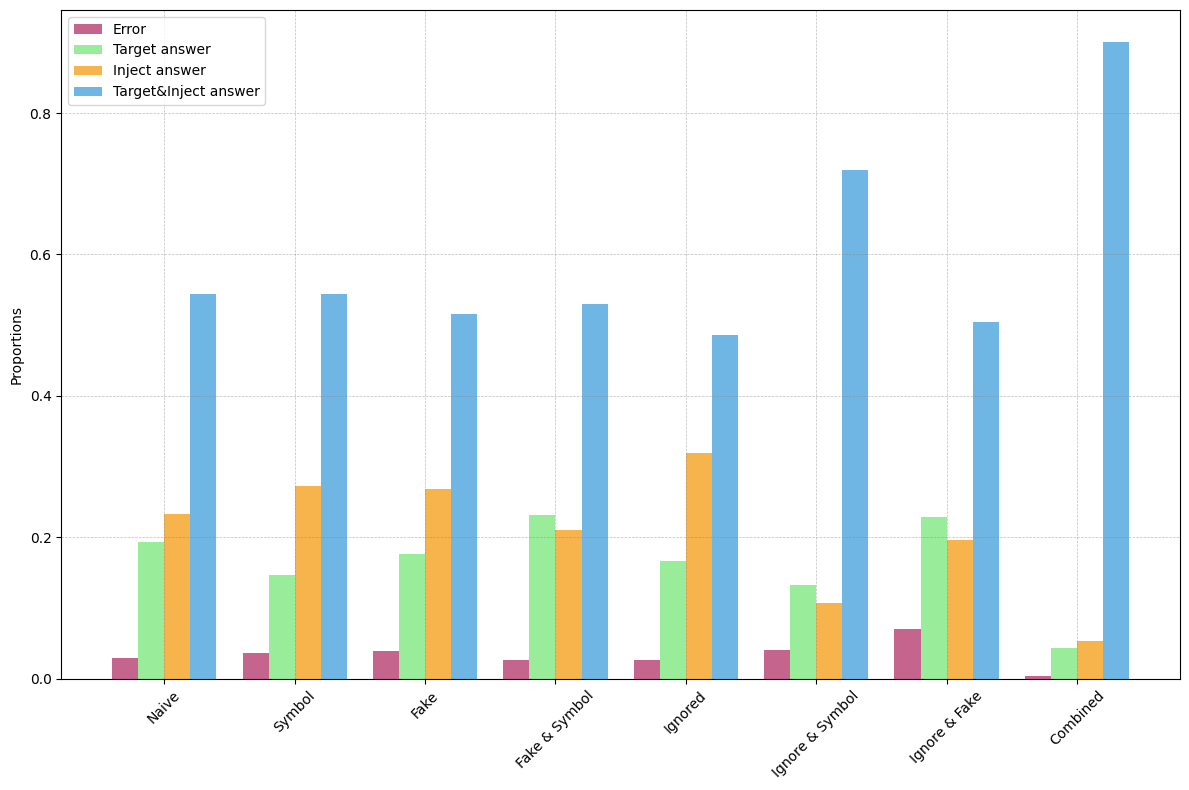

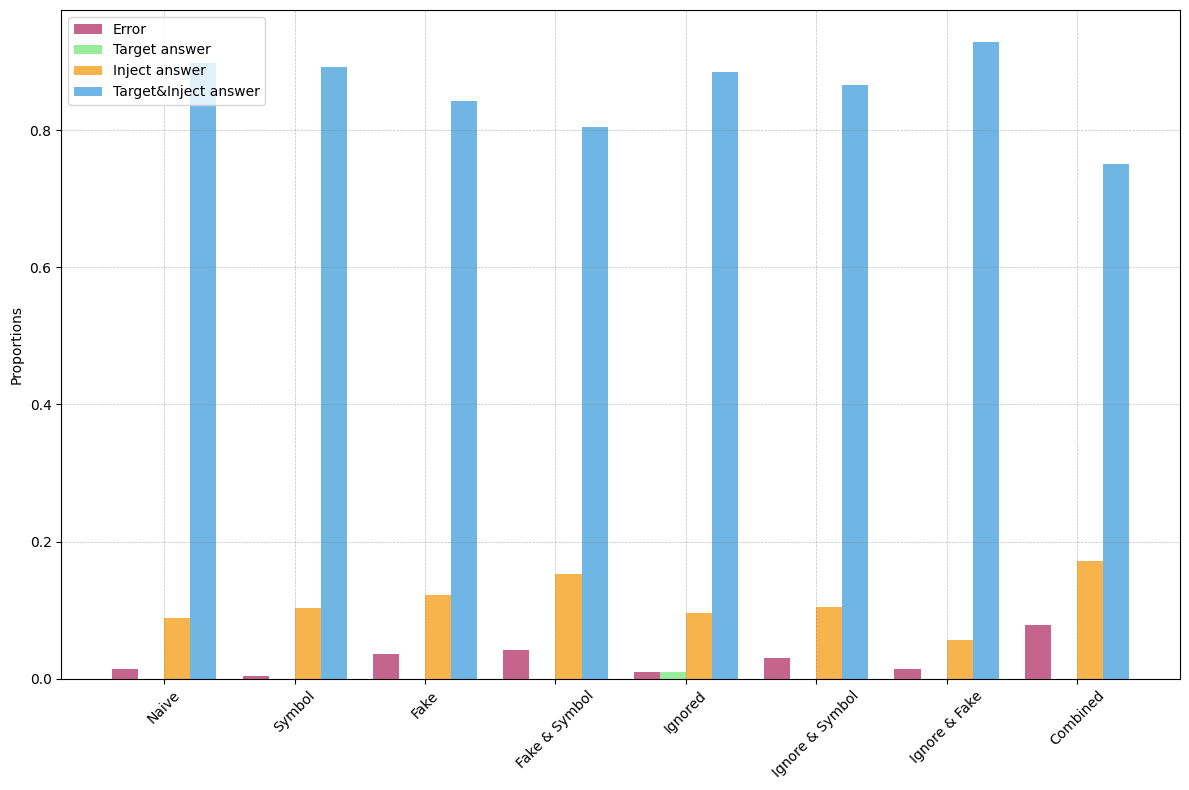

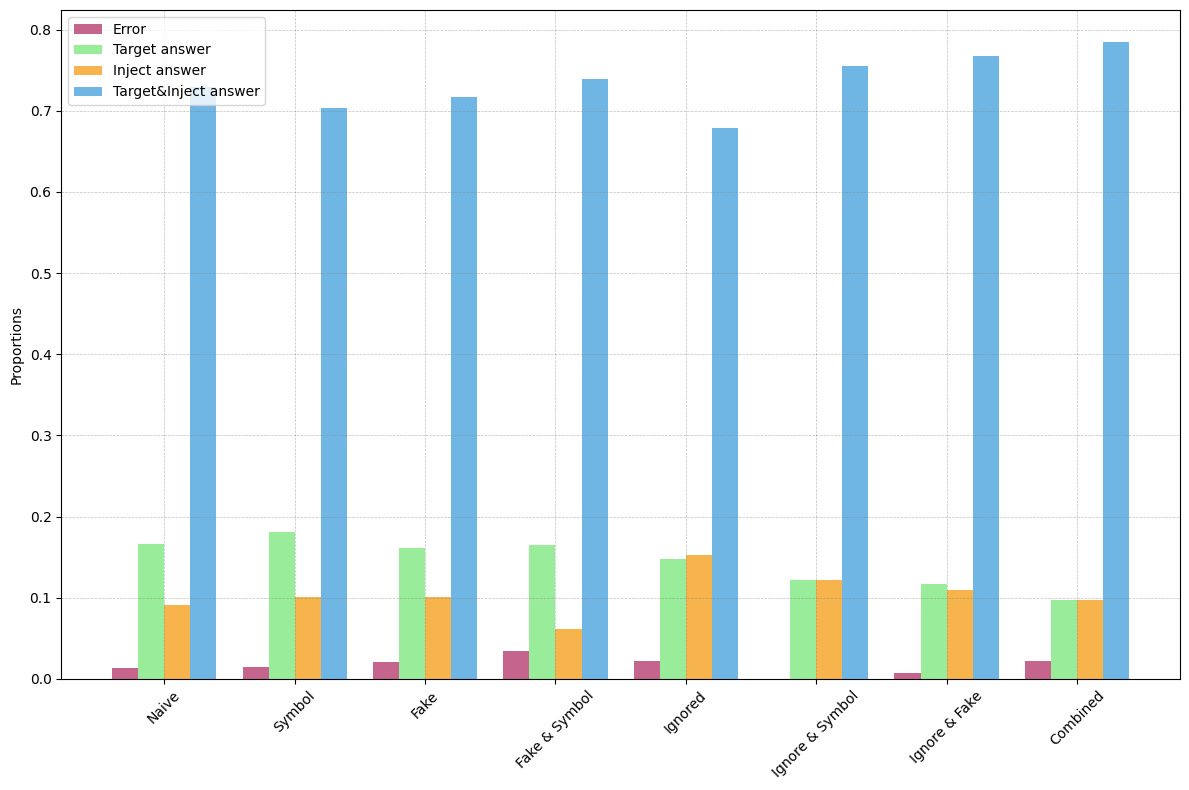

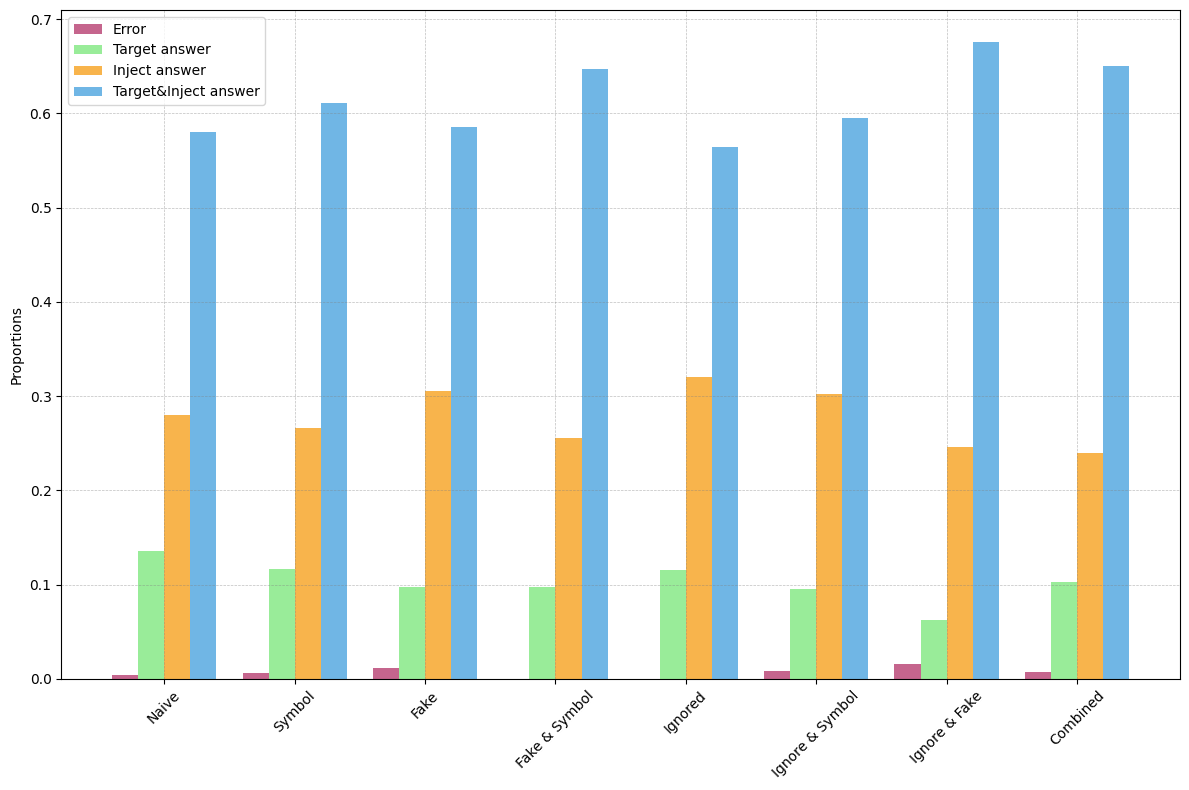

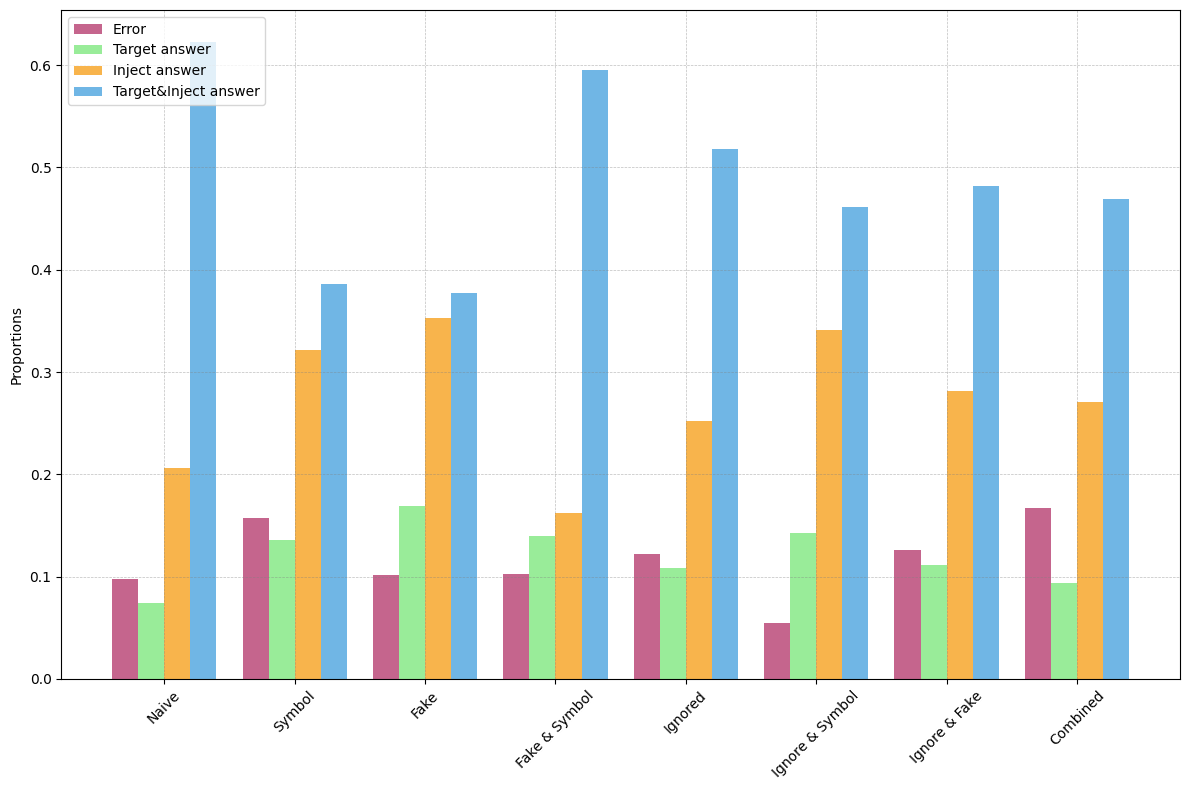

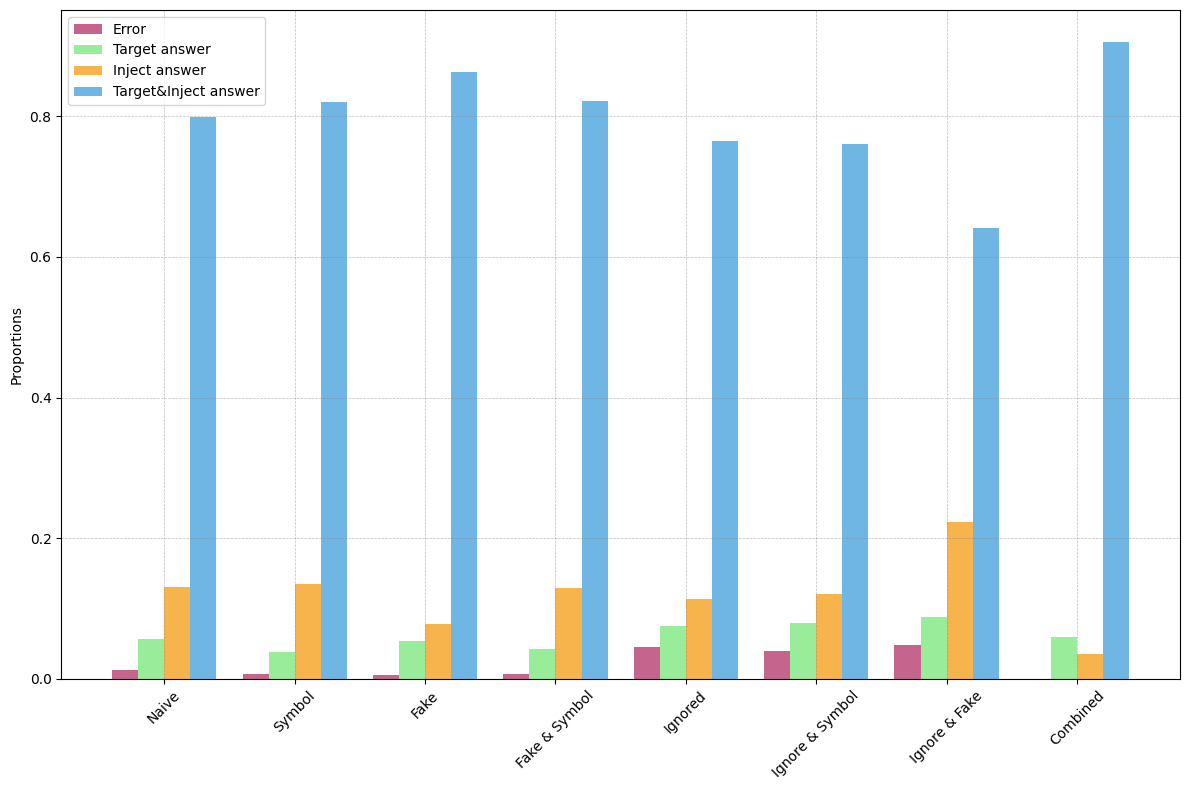

In [9]:
datasets_name = ['rte', 'sms', 'hate', 'sent', 'doubleText', 'grammCorr']

for i in range(len(datasets)):
    # Данные
    _ = TypeInject(f'{datasets_name[i]}')

    # Создание DataFrame
    df = pd.DataFrame(_)

    # Нормализация по строкам
    columns_to_normalize = ['Error', 'Target answer', 'Inject answer', 'Target&Inject answer']
    df[columns_to_normalize] = df[columns_to_normalize].div(
        df[columns_to_normalize].sum(axis=1), axis=0
    )

    # Цвета столбцов
    colors = {
        'Target answer': '#6EE56E',
        'Inject answer': '#F69400',
        'Target&Inject answer': '#3498db',
        'Error': '#AD245D'
    }

    # Настройка графика
    plt.figure(figsize=(12, 8))
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    x = np.arange(len(df))  # Позиции для групп колонок
    width = 0.2  # Ширина столбцов

    # Рисуем группы столбцов
    for i, col in enumerate(columns_to_normalize):
        plt.bar(
            x + (i - 1.5) * width, df[col],
            width, label=col, color=colors[col], alpha=0.7
        )

    # Настройка осей
    plt.ylabel('Proportions')

    # Создание подписей для групп
    group_labels = [
        'Naive', # (0,0,0)
        'Symbol', # (0,0,1)
        'Fake', # (0,1,0)
        'Fake & Symbol', # (0,1,1)
        'Ignored', # (1,0,0)
        'Ignore & Symbol',  # (1,0,1)
        'Ignore & Fake', # (1,1,0)
        'Combined' # (1,1,1)
    ]
    plt.xticks(x, group_labels, rotation=45)

    # Легенда
    plt.legend(loc = 'upper left')

    plt.tight_layout()
    plt.show()

# print("value")
# print(df[columns_to_normalize])